# FastAI - computer vision

## Ressources

* [Building a simple image recognition system with fast.ai](https://medium.com/innova-technology/building-a-simple-image-recognition-system-with-fast-ai-858104dbf9bb)
* 

## Notebook setup

In [ ]:
# !! execute in bash !!

# ! python3 -m venv fastai
# ! source fastai/bin/activate
# ! pip install ipykernel
# ! pip install fastai fastbook
# ! python -m ipykernel install --user --name=fastai

In [1]:
import sys
import fastai
import inspect
from pathlib import Path
from fastbook import search_images_ddg
from fastai.vision.utils import *
from fastai.data.transforms import get_image_files
from fastai.vision.all import *

print("Kernel:", sys.executable)
print("Python:", sys.version)
print("FastAI:", fastai.__version__)

Kernel: /home/hendrik/Documents/repos/github/mygists/fastai/bin/python
Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
FastAI: 2.7.15


## Data gathering

Collect images from the internet using DuckDuckGo (no setup required). Here we are gathering URLS of apples, pears and cherries and store them in subfolders. 

In [2]:
img_types = 'apples', 'pears', 'cherries', 'bananas', 'oranges', 'peaches', 'strawberries', 'raspberries'
img_path = Path('fastai_vision_data/fruits')
img_path.mkdir(exist_ok = True)

In [3]:
%%script false --no-raise-error

for i in img_types:
    dst = (img_path / i)
    dst.mkdir(exist_ok = True)
    urls = search_images_ddg(
        f'{i} fruit'
        , max_images = 100
    )
    download_images(
        dst
        , urls = urls
    )

Frequently some of the downloaded files are corrupt. `verify_images` from `fastai.vision.utils` checks if images can be opened. 

In [5]:
fls = get_image_files(img_path)
fld = verify_images(fls)

# list(fls)
# list(fld)

In [6]:
fld.map(Path.unlink)
fld.map(fls.remove)

(#15) [None,None,None,None,None,None,None,None,None,None...]

In [7]:
png = [f for f in list(fls.map(str)) if f.endswith('.png')]

for p in png:
  im = Image.open(p)
  if im.format == 'PNG':
    if im.mode != 'RGBA':
      im.convert("RGBA").save(f"{p}")

## Data loader

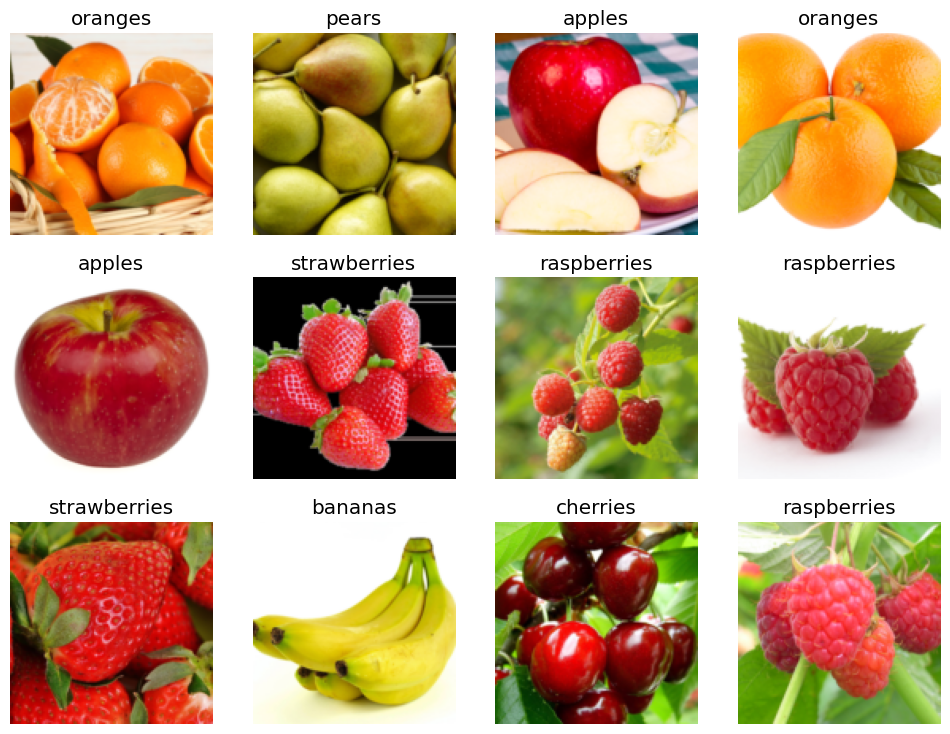

In [8]:
frt = DataBlock(
    blocks = (ImageBlock, CategoryBlock)
    , get_items = get_image_files
    , splitter = RandomSplitter(valid_pct = 0.2, seed = 42)
    , get_y = parent_label
    , item_tfms = Resize(128)
)

dls = frt.dataloaders(img_path)
dls.valid.show_batch(max_n = 12, nrows = 3)

## Vision learner

In [9]:
lrn = vision_learner(
    dls
    , arch = resnet18
    , metrics = error_rate
)

In [10]:
# lrn.fine_tune(2, base_lr = 0.005)
lrn.fine_tune(0, base_lr = 0.005)

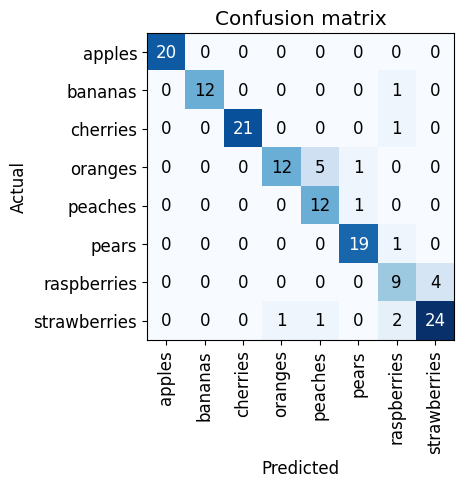

In [11]:
interp = ClassificationInterpretation.from_learner(lrn) 
interp.plot_confusion_matrix()

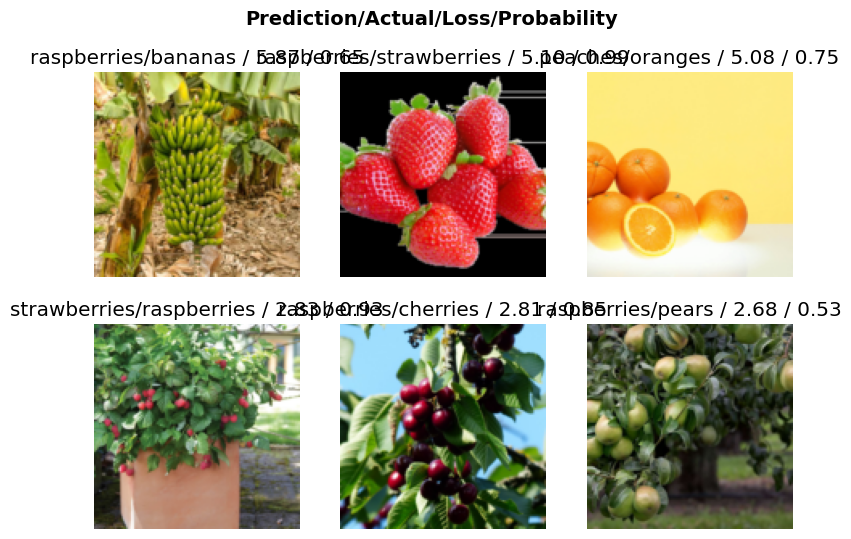

In [14]:
interp.plot_top_losses(6, nrows = 2)

## Single-label classification

In [ ]:
path = untar_data(URLs.PETS)
path.ls()

In [26]:
fls = get_image_files(path/'images')

Create a function to define the label which is dog in case of a lowercase first letter of the filename and cat otherwise.

In [36]:
def label_fun(f):
    return f[0].isupper()

False

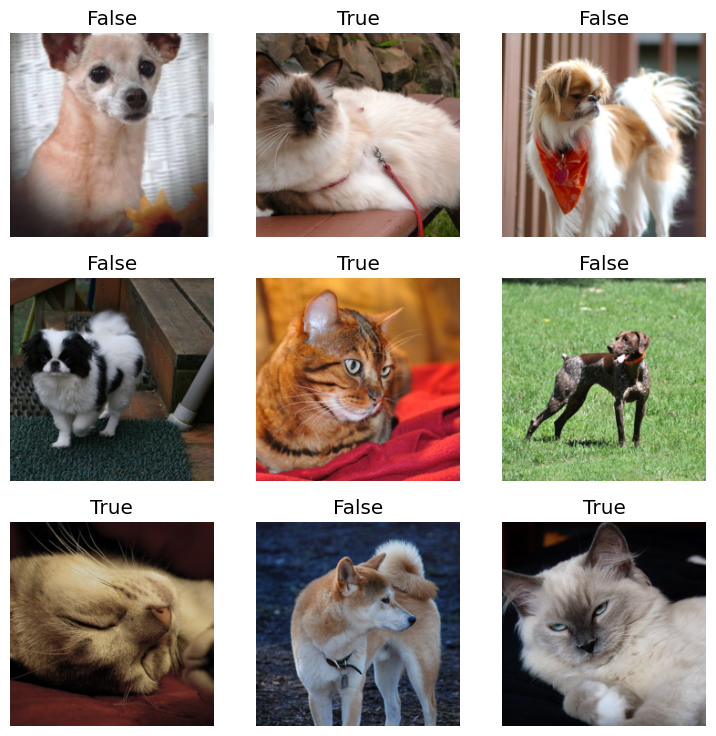

In [41]:
dls = ImageDataLoaders.from_name_func(
    path
    , fnames = fls
    , label_func = label_fun
    , item_tfms = Resize(224)
)

dls.show_batch()

In [42]:
learn = vision_learner(
    dls
    , arch = resnet34
    , metrics = error_rate
)

# learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/hendrik/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:12<00:00, 7.11MB/s]


In [60]:
# display(load_image(fls[0])), learn.predict(fls[0])
img = Image.open(fls[0])
# img.resize((300, 200))
print('shape:', img.shape)
print('pixels:', img.n_px)
print('aspect:', round(img.aspect, ndigits = 1))

shape: (333, 500)
pixels: 166500
aspect: 1.5


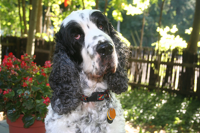

In [65]:
img.to_thumb(200)

In [67]:
ten = image2tensor(img)
ten.shape

torch.Size([3, 333, 500])

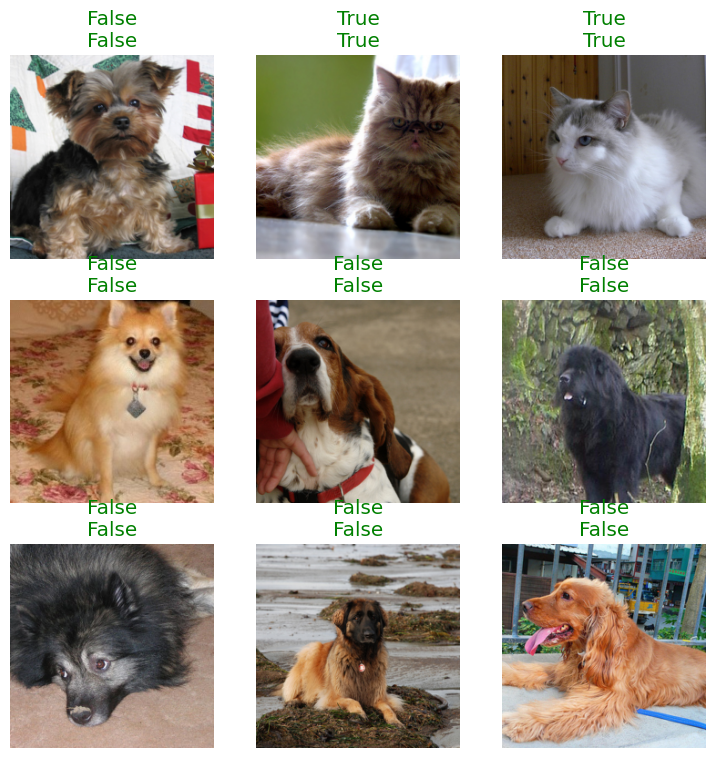

In [48]:
learn.show_results()

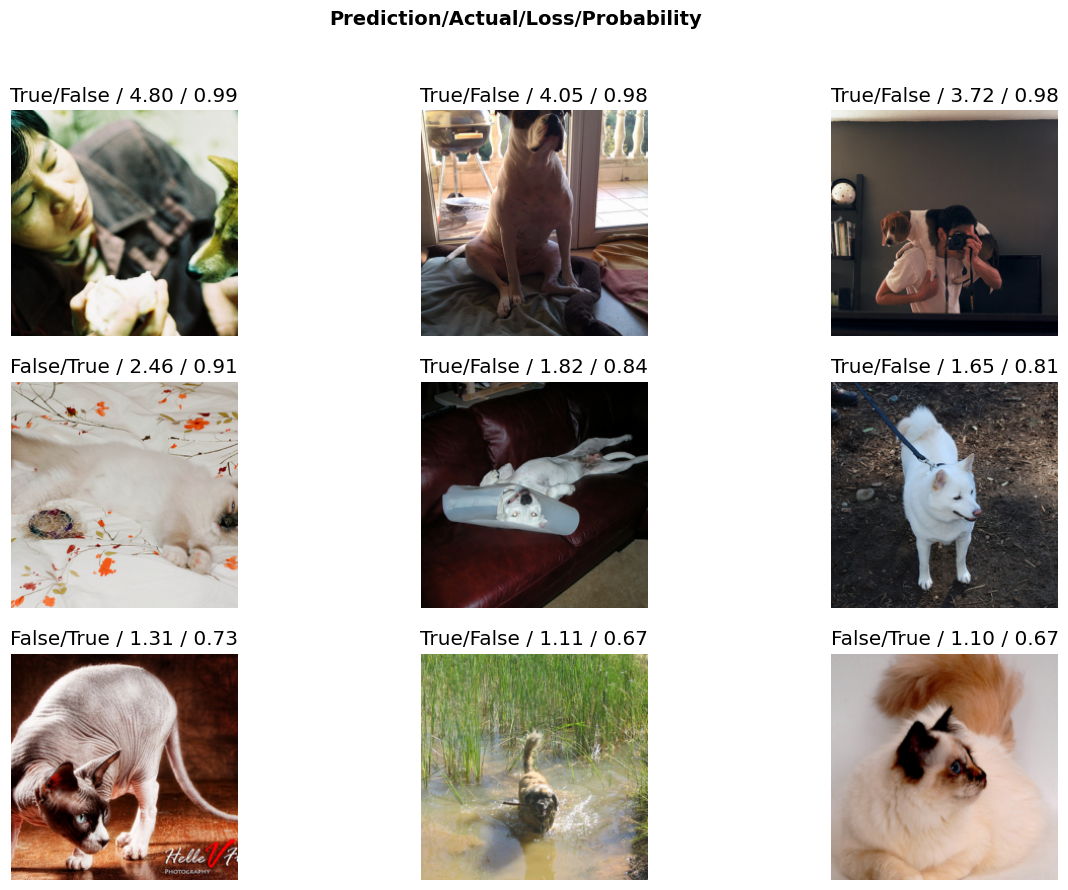

In [49]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize = (15, 10))